In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,20)

In [21]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\KIIT\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


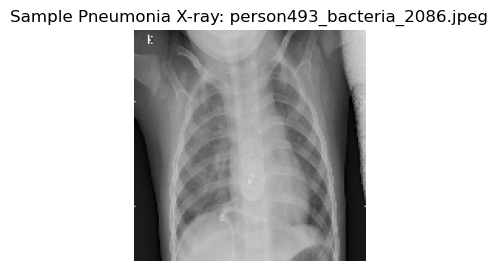

In [45]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# Define dataset path
train_pneumonia_path = os.path.join(dataset_path, "train", "PNEUMONIA")

if os.path.exists(train_pneumonia_path):
    files = os.listdir(train_pneumonia_path)
    if files:
        random_image = random.choice(files)  # Select a random image
        sample_image_path = os.path.join(train_pneumonia_path, random_image)

        # Load the image in grayscale
        image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error: Could not load image {sample_image_path}.")
        else:
            # Resize to model input size
            image = cv2.resize(image, (150, 150))

            # Convert grayscale (H, W, 1) to RGB (H, W, 3)
            image = np.expand_dims(image, axis=-1)  # (150, 150, 1)
            image = np.repeat(image, 3, axis=-1)    # (150, 150, 3)

            # Add batch dimension for model input (1, 150, 150, 3)
            image = np.expand_dims(image, axis=0)

            # Display the image
            plt.figure(figsize=(6,3))
            plt.imshow(image[0], cmap='gray')
            plt.title(f"Sample Pneumonia X-ray: {random_image}")
            plt.axis("off")
            plt.show()
    else:
        print("No images found in PNEUMONIA folder.")
else:
    print("PNEUMONIA folder NOT found. Check dataset structure.")


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

print("Class labels:", train_generator.class_indices)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (0=Normal, 1=Pneumonia)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9458 - loss: 0.1506 - val_accuracy: 0.9463 - val_loss: 0.1472
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9491 - loss: 0.1320 - val_accuracy: 0.9425 - val_loss: 0.1555
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9642 - loss: 0.0949 - val_accuracy: 0.9482 - val_loss: 0.1331
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9706 - loss: 0.0971 - val_accuracy: 0.9540 - val_loss: 0.1338
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9779 - loss: 0.0670 - val_accuracy: 0.9655 - val_loss: 0.1160


In [59]:
model.save("pneumonia_detection_model.h5")